In [1]:
import pandas as pd
from pandas_profiling import ProfileReport
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
# Importo los csv con los datos
df_datos_encuesta = pd.read_csv('tp-2020-2c-train-cols2.csv')
df_encuesta = pd.read_csv('tp-2020-2c-train-cols1.csv')

In [3]:
# Inspeccionamos las columnas que forman los datos
df_datos_encuesta.head()

,tipo_de_sala,nombre,id_usuario,genero,edad,amigos,parientes,id_ticket,precio_ticket,fila,nombre_sede
0,4d,Señor Camilo Pedro,117,hombre,73.5,0,0,59258;,1,NaN,fiumark_quilmes
1,4d,Señora Raquel Angelica,658,mujer,35.0,1,1,586:6;,2,NaN,fiumark_quilmes
2,normal,Señor Antonio Federico,794,hombre,NaN,0,0,"RE""39822",3,NaN,fiumark_chacarita
3,4d,Señor Osvaldo Aureliano,455,hombre,NaN,0,0,"C17""4:39",1,NaN,fiumark_palermo
4,4d,Señorita Rita Eudosia,173,mujer,4.0,1,1,569964,2,NaN,fiumark_palermo


In [4]:
# Inspeccionamos las dimensiones iniciales del dataframe
df_datos_encuesta.shape

(801, 11)

In [5]:
# Eliminamos las columna "id_ticket" y "nombre" porque no nos aportan información relavante para la predicción
df_datos_encuesta.drop(columns=['nombre', 'id_ticket'], inplace=True)

In [6]:
# DEBUG
df_datos_encuesta.head()

,tipo_de_sala,id_usuario,genero,edad,amigos,parientes,precio_ticket,fila,nombre_sede
0,4d,117,hombre,73.5,0,0,1,NaN,fiumark_quilmes
1,4d,658,mujer,35.0,1,1,2,NaN,fiumark_quilmes
2,normal,794,hombre,NaN,0,0,3,NaN,fiumark_chacarita
3,4d,455,hombre,NaN,0,0,1,NaN,fiumark_palermo
4,4d,173,mujer,4.0,1,1,2,NaN,fiumark_palermo


In [7]:
# Analizamos la integridad de las columnas amigos y parientes 
# Verificamos que no tengan valores nulos y que solo tengan valores numericos enteros positivos
# Para cear una nueva columna 'cantidad_acompanantes' que sea la suma de estas dos

In [8]:
df_datos_encuesta['amigos'].isnull().sum()

0

In [9]:
df_datos_encuesta['parientes'].isnull().sum()

0

In [10]:
df_datos_encuesta['amigos'].value_counts()

0    557
1    179
2     25
4     15
3     14
8      6
5      5
Name: amigos, dtype: int64

In [11]:
df_datos_encuesta['parientes'].value_counts()

0    607
1    110
2     70
3      5
5      4
4      4
6      1
Name: parientes, dtype: int64

In [12]:
df_datos_encuesta['cantidad_acompanantes'] = df_datos_encuesta['amigos'] + df_datos_encuesta['parientes']

In [13]:
# DEBUG
df_datos_encuesta.head()

,tipo_de_sala,id_usuario,genero,edad,amigos,parientes,precio_ticket,fila,nombre_sede,cantidad_acompanantes
0,4d,117,hombre,73.5,0,0,1,NaN,fiumark_quilmes,0
1,4d,658,mujer,35.0,1,1,2,NaN,fiumark_quilmes,2
2,normal,794,hombre,NaN,0,0,3,NaN,fiumark_chacarita,0
3,4d,455,hombre,NaN,0,0,1,NaN,fiumark_palermo,0
4,4d,173,mujer,4.0,1,1,2,NaN,fiumark_palermo,2


In [14]:
# Elimino las columnas amigos y parientes
df_datos_encuesta.drop(columns=['amigos', 'parientes'],axis=1, inplace=True)

In [15]:
# DEBUG
df_datos_encuesta.head()

,tipo_de_sala,id_usuario,genero,edad,precio_ticket,fila,nombre_sede,cantidad_acompanantes
0,4d,117,hombre,73.5,1,NaN,fiumark_quilmes,0
1,4d,658,mujer,35.0,2,NaN,fiumark_quilmes,2
2,normal,794,hombre,NaN,3,NaN,fiumark_chacarita,0
3,4d,455,hombre,NaN,1,NaN,fiumark_palermo,0
4,4d,173,mujer,4.0,2,NaN,fiumark_palermo,2


In [16]:
# Nos parece relevante si fue acompañado o no, por eso creamos un nueva columna 'fue_acompanado' para falicitar el uso
df_datos_encuesta['fue_acompanado'] = df_datos_encuesta['cantidad_acompanantes'].apply(lambda x: 'Si' if x > 0 else 'No')

In [17]:
# DEBUG
df_datos_encuesta.head()

,tipo_de_sala,id_usuario,genero,edad,precio_ticket,fila,nombre_sede,cantidad_acompanantes,fue_acompanado
0,4d,117,hombre,73.5,1,NaN,fiumark_quilmes,0,No
1,4d,658,mujer,35.0,2,NaN,fiumark_quilmes,2,Si
2,normal,794,hombre,NaN,3,NaN,fiumark_chacarita,0,No
3,4d,455,hombre,NaN,1,NaN,fiumark_palermo,0,No
4,4d,173,mujer,4.0,2,NaN,fiumark_palermo,2,Si


In [18]:
# Analizamos la columna 'tipo_de_sala'
# Verificamos que no tenga valores nulos
df_datos_encuesta['tipo_de_sala'].isnull().sum()

0

In [19]:
df_datos_encuesta['tipo_de_sala'].value_counts()

4d        447
normal    187
3d        167
Name: tipo_de_sala, dtype: int64

In [20]:
# Reemplazamos normal por 2d
df_datos_encuesta['tipo_de_sala'].replace(to_replace='normal', value='2d', inplace=True)

In [21]:
# DEBUG
df_datos_encuesta['tipo_de_sala'].value_counts()

4d    447
2d    187
3d    167
Name: tipo_de_sala, dtype: int64

In [22]:
# DEBUG
df_datos_encuesta.head()

,tipo_de_sala,id_usuario,genero,edad,precio_ticket,fila,nombre_sede,cantidad_acompanantes,fue_acompanado
0,4d,117,hombre,73.5,1,NaN,fiumark_quilmes,0,No
1,4d,658,mujer,35.0,2,NaN,fiumark_quilmes,2,Si
2,2d,794,hombre,NaN,3,NaN,fiumark_chacarita,0,No
3,4d,455,hombre,NaN,1,NaN,fiumark_palermo,0,No
4,4d,173,mujer,4.0,2,NaN,fiumark_palermo,2,Si


In [23]:
# Quito 'fiumark' del nombre de la sede, para una mejor visualizacion en los graficos
df_datos_encuesta.replace(to_replace = 'fiumark_quilmes', value ='Quilmes', inplace=True) 
df_datos_encuesta.replace(to_replace = 'fiumark_chacarita', value ='Chacarita', inplace=True) 
df_datos_encuesta.replace(to_replace = 'fiumark_palermo', value ='Palermo', inplace=True) 

In [24]:
# DEBUG
df_datos_encuesta.head()

,tipo_de_sala,id_usuario,genero,edad,precio_ticket,fila,nombre_sede,cantidad_acompanantes,fue_acompanado
0,4d,117,hombre,73.5,1,NaN,Quilmes,0,No
1,4d,658,mujer,35.0,2,NaN,Quilmes,2,Si
2,2d,794,hombre,NaN,3,NaN,Chacarita,0,No
3,4d,455,hombre,NaN,1,NaN,Palermo,0,No
4,4d,173,mujer,4.0,2,NaN,Palermo,2,Si


In [25]:
# Analizamos la columna 'id_usuario' es busca de usuarios repetidos
df_datos_encuesta['id_usuario'].duplicated(keep=False).value_counts()

False    801
Name: id_usuario, dtype: int64

In [26]:
# Verifico que no tenga valores nulos
df_datos_encuesta['id_usuario'].isnull().sum()

0

In [27]:
# Analizamos la columna 'nombre_sede', verificamos que no tenga valores nulos
df_datos_encuesta['nombre_sede'].isnull().sum()

2

In [28]:
# En este caso como solo tiene 2 filas con valores null las descartamos
bool_nombre_sede = pd.notnull(df_datos_encuesta['nombre_sede'])  
df_datos_encuesta = df_datos_encuesta[bool_nombre_sede]  

In [29]:
df_datos_encuesta['nombre_sede'].value_counts()

Palermo      579
Chacarita    149
Quilmes       71
Name: nombre_sede, dtype: int64

In [30]:
# DEBUG
df_datos_encuesta.shape

(799, 9)

In [31]:
# Verifico que la columna genero no tenga nulos y solo tenga valores mujer/hombre
df_datos_encuesta['genero'].isnull().sum()

0

In [32]:
df_datos_encuesta['genero'].value_counts()

hombre    513
mujer     286
Name: genero, dtype: int64

In [33]:
# Analizamos la columna 'fila'
df_datos_encuesta['fila'].isnull().sum()

624

In [34]:
# Como la mayoria de los valores de esta columna son nulos decidimos eliminarla
df_datos_encuesta.drop(columns='fila', inplace=True)

In [35]:
# DEBUG
df_datos_encuesta.head()

,tipo_de_sala,id_usuario,genero,edad,precio_ticket,nombre_sede,cantidad_acompanantes,fue_acompanado
0,4d,117,hombre,73.5,1,Quilmes,0,No
1,4d,658,mujer,35.0,2,Quilmes,2,Si
2,2d,794,hombre,NaN,3,Chacarita,0,No
3,4d,455,hombre,NaN,1,Palermo,0,No
4,4d,173,mujer,4.0,2,Palermo,2,Si


In [36]:
# Analizamos la columna 'edad' 
# Tiene nulos pero no tantos teniendo en cuenta el tamano del dataset
# Falta analizar la columna precio con lo de la clase practica del 07/10
df_datos_encuesta['edad'].isnull().sum()

160

In [37]:
# Analizamos el dataframe df_prediccion, verificando que no tenga valores null
df_encuesta.head()

,id_usuario,volveria
0,117,0
1,658,0
2,794,0
3,455,0
4,173,1


In [38]:
df_encuesta.shape

(801, 2)

In [39]:
df_encuesta.isnull().sum()

id_usuario    0
volveria      0
dtype: int64

In [40]:
# Analizamos la columna 'id_usuario' es busca de usuarios repetidos
df_encuesta['id_usuario'].duplicated(keep=False).value_counts()

False    801
Name: id_usuario, dtype: int64

In [41]:
# Mergeamos los dataframe
df = pd.merge(left = df_datos_encuesta, right = df_encuesta, how = 'inner', on = 'id_usuario')

In [42]:
df.head()

,tipo_de_sala,id_usuario,genero,edad,precio_ticket,nombre_sede,cantidad_acompanantes,fue_acompanado,volveria
0,4d,117,hombre,73.5,1,Quilmes,0,No,0
1,4d,658,mujer,35.0,2,Quilmes,2,Si,0
2,2d,794,hombre,NaN,3,Chacarita,0,No,0
3,4d,455,hombre,NaN,1,Palermo,0,No,0
4,4d,173,mujer,4.0,2,Palermo,2,Si,1


In [43]:
# DEBUG
df.shape

(799, 9)

In [44]:
# Elimino la columna id_usuario, porque ya no nos aporta informacion
df.drop(columns=['id_usuario'], axis=1, inplace=True)

In [45]:
# DEBUG
df.head()

,tipo_de_sala,genero,edad,precio_ticket,nombre_sede,cantidad_acompanantes,fue_acompanado,volveria
0,4d,hombre,73.5,1,Quilmes,0,No,0
1,4d,mujer,35.0,2,Quilmes,2,Si,0
2,2d,hombre,NaN,3,Chacarita,0,No,0
3,4d,hombre,NaN,1,Palermo,0,No,0
4,4d,mujer,4.0,2,Palermo,2,Si,1


In [46]:
# Usamos pandas profiling para comprender mejor los datos
report = ProfileReport(df, title='FiuMark', minimal=False)
report

<AxesSubplot:ylabel='¿Volvería?'>

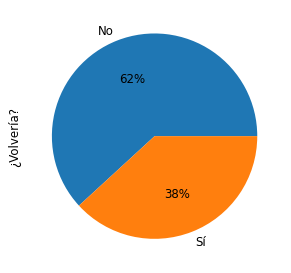

In [47]:
# Graficos

# Vemos en porcentaje si las personas volverían o no
plt.figure(dpi=85)
df.volveria.replace(to_replace=[True, False], value=["Sí", "No"]).value_counts().plot(kind='pie', autopct='%1.0f%%', ylabel='¿Volvería?')

# Podemos apreciar que la mayoría de los espectadores no volverían

<AxesSubplot:title={'center':'Cantidad de espectadores por tipo de sala'}, xlabel='Tipo de sala', ylabel='Cantidad de espectadores'>

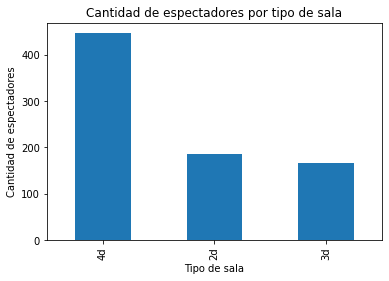

In [48]:
# Graficamente vemos que la mayoria de los encuestados concurrieron a salas 4D
df['tipo_de_sala'].value_counts().sort_values(ascending=False) \
.plot(title = 'Cantidad de espectadores por tipo de sala', 
      xlabel = 'Tipo de sala', 
      ylabel = 'Cantidad de espectadores',
      kind='bar')

<AxesSubplot:title={'center':'Porcentaje de espectadores por sede'}>

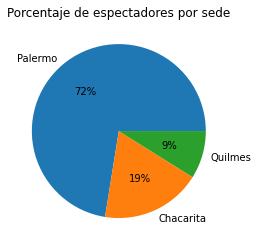

In [49]:
# La mayoria de las personas concurrieron a la sede de Palermo
df['nombre_sede'].value_counts().sort_values(ascending=False) \
.plot(title = 'Porcentaje de espectadores por sede', 
      ylabel = '',
      kind='pie', 
      autopct='%1.0f%%')

<Figure size 900x600 with 0 Axes>

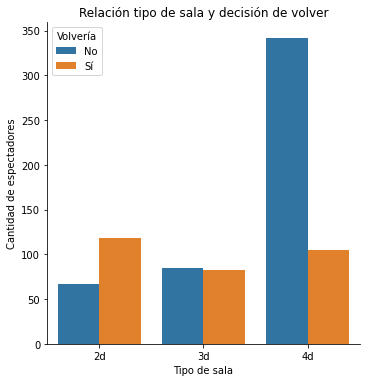

In [50]:
# Comparamos la sala a la que fueron y la decisión de volver
plt.figure(dpi=150)
df_aux = df[["volveria", "tipo_de_sala"]].value_counts().reset_index()
df_aux.columns.values[2] = 'count'
df_aux.volveria.replace(to_replace=[True, False], value=["Sí", "No"], inplace=True)

sns.catplot(data=df_aux, x='tipo_de_sala', y='count', hue='volveria', kind='bar', 
                legend=False, order=['2d', '3d', '4d'])

plt.legend(title = "Volvería")
plt.ylabel("Cantidad de espectadores")
plt.xlabel("Tipo de sala")
plt.title('Relación tipo de sala y decisión de volver')
plt.show()

<Figure size 900x600 with 0 Axes>

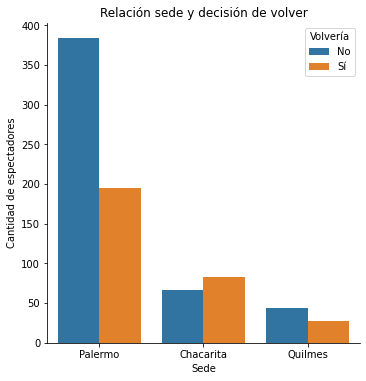

In [51]:
# Comparamos la sede a la que fueron y la decisión de volver
plt.figure(dpi=150)
df_aux = df[["volveria", "nombre_sede"]].value_counts().reset_index()
df_aux.columns.values[2] = 'count'
df_aux.volveria.replace(to_replace=[True, False], value=["Sí", "No"], inplace=True)
df_aux.nombre_sede.replace({'fiumark_':''}, regex=True, inplace=True)

sns.catplot(data=df_aux, x='nombre_sede', y='count', hue='volveria', kind='bar', legend=False)

plt.legend(title = "Volvería")
plt.ylabel("Cantidad de espectadores")
plt.xlabel("Sede")
plt.title('Relación sede y decisión de volver')
plt.show()

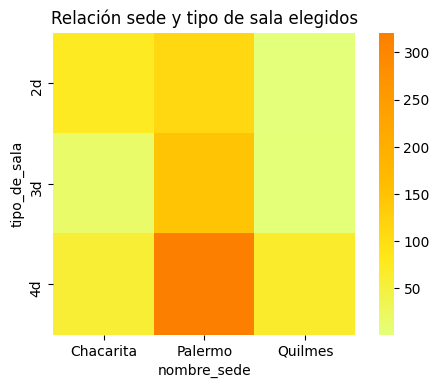

In [52]:
# Vemos cuales fueron las salas más elegidas según las sedes
plt.figure(dpi=100)

df_aux = df[["tipo_de_sala", "nombre_sede"]].value_counts().reset_index()
df_aux.columns.values[2] = 'count'
df_aux.nombre_sede.replace({'fiumark_':''}, regex=True, inplace=True)

df_aux = df_aux.pivot("tipo_de_sala", "nombre_sede", "count")

plt.title('Relación sede y tipo de sala elegidos')
sns.heatmap(df_aux, square=True, cmap="Wistia", xticklabels=True)
plt.show()

# Podemos ver que para todos los tipos de salas la sede más elegida fue Palermo 
# y que la sala 4d de Palermo fue la más elegida de todas.

<AxesSubplot:ylabel='Género'>

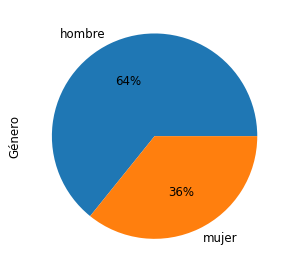

In [53]:
# Vemos en porcentaje el género de los espectadores
plt.figure(dpi=85)
df.genero.value_counts().plot(kind='pie', autopct='%1.0f%%', ylabel='Género')

# Podemos ver que en su mayoría los espectadores son hombres

<Figure size 900x600 with 0 Axes>

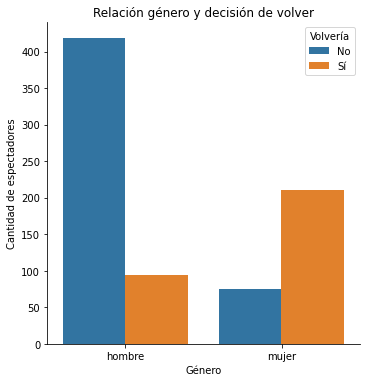

In [54]:
# Comparamos el género y la decisión de volver
plt.figure(dpi=150)
df_aux = df[["volveria", "genero"]].value_counts().reset_index()
df_aux.columns.values[2] = 'count'
df_aux.volveria.replace(to_replace=[True, False], value=["Sí", "No"], inplace=True)

sns.catplot(data=df_aux, x='genero', y='count', hue='volveria', kind='bar', legend=False)

plt.title('Relación género y decisión de volver')
plt.legend(title = "Volvería")
plt.ylabel("Cantidad de espectadores")
plt.xlabel("Género")
plt.show()

# Podemos apreciar que incluso mientras que la cantidad de hombres que participaron es mayor que la cantidad
# de mujeres, es significativamente mayor la cantidad de mujeres que decidirían volver comparada con la 
# cantidad de hombres que elegirían volver.

<AxesSubplot:title={'center':'Espectadores acompañados vs solos'}, ylabel='Cantidad de espectadores'>

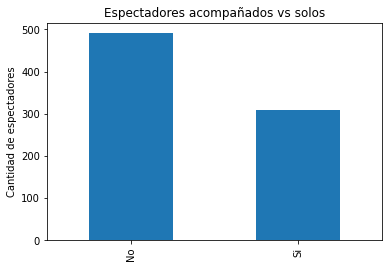

In [55]:
# La mayoria de las personas no van acompanadas al cine
df['fue_acompanado'].value_counts().sort_values(ascending=False) \
.plot(title = 'Espectadores acompañados vs solos', 
      ylabel = 'Cantidad de espectadores',
      kind='bar')

<AxesSubplot:title={'center':'distribucion de la cantidad de acompañantes'}, ylabel='Frequency'>

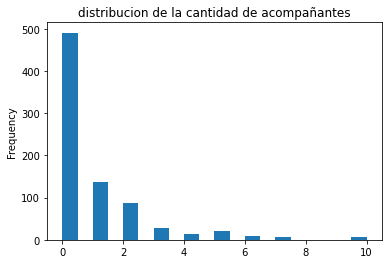

In [56]:
# Vemos la distribucion de la cantidad de acompañantes 
df['cantidad_acompanantes'] \
.plot(title = 'distribucion de la cantidad de acompañantes', 
      ylabel = '',
      kind='hist', 
      bins=20)

<AxesSubplot:xlabel='precio_ticket', ylabel='cantidad_acompanantes'>

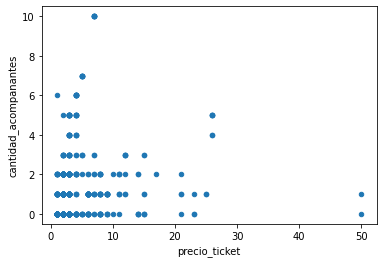

In [57]:
df.plot(
    x='precio_ticket',
    y='cantidad_acompanantes',
    kind='scatter',
)

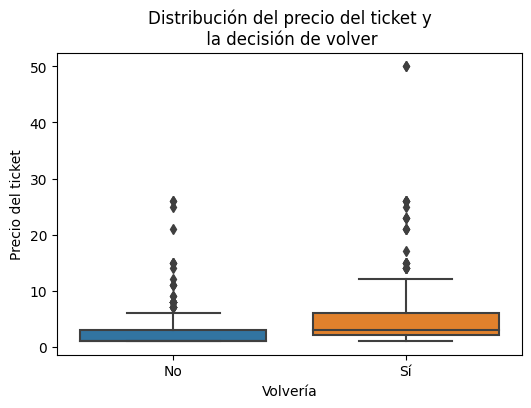

In [58]:
plt.figure(dpi=100)
plt.title("Distribución del precio del ticket y\n la decisión de volver")
sns.boxplot(
    data=df,
    y='precio_ticket',
    x='volveria'
)
plt.ylabel("Precio del ticket")
plt.xlabel("Volvería")
plt.xticks([False, True], ["No", "Sí"])
plt.show()

In [59]:
#df.drop(columns=['edad'], inplace=True)

from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(df)

ModuleNotFoundError: No module named 'sklearn'

In [ ]:
pca.explained_variance_ratio_